In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import imageio

import os
import dill
import sys
sys.path.append('../../')

In [2]:
#.manual_seed(1)    # reproducible
real_data=True
dt=1e-2
if real_data:
    n = 4
    sys_name = 'analytic_koop_sys'
    directory = os.path.abspath("")                                     # Path to save learned models
    infile = open(directory + '/data/' + sys_name + '_data.pickle', 'rb')
    xs_train, t_train, n_traj_train, xs_val, t_val, n_traj_val = dill.load(infile)
    infile.close()
    
    xs = xs_train[:,:-1,:]
    xs_prime = xs_train[:,1:,:]
    order = 'F'
    n_data_pts = n_traj_train * (xs.shape[1])
    x_flat = xs.T.reshape((n, n_data_pts), order=order)
    x_prime_flat = xs_prime.T.reshape((n, n_data_pts), order=order)

    x = x_flat.T
    y = x_prime_flat.T - x
    x, y = x[:,2:], y[:,2:]
    X = np.concatenate((x, x+y), axis=1)
    X, y = torch.Tensor(X), torch.Tensor(y)
    
else:
    mu, lambd = -0.3, -0.6
    min_x = [-1., -1.]
    max_x = [1., 1.]
    n_pts = 500
    x = torch.Tensor(np.random.uniform(min_x, max_x, (n_pts,2)))  # x data (tensor), shape=(100, 1)
    y = dt*torch.cat((mu*x[:,0].reshape(-1,1), (-lambd*x[:,0].pow(2) + lambd*x[:,1]).reshape(-1,1)), 1)# + dt*0.2*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)
    X = torch.cat((x, x+y),1)

# torch can only train on Variable, so convert them to Variable
X, y = Variable(X), Variable(y)

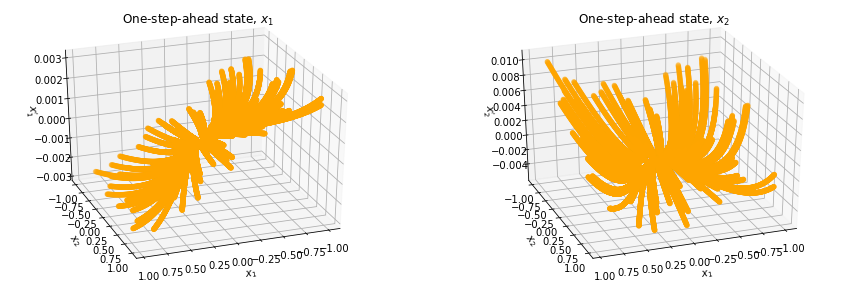

In [3]:
# view data
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[:,0].data.numpy(), X[:,1].data.numpy(), y[:,0].data.numpy(), color = "orange")
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel("$x_1'$")
ax.set_title('One-step-ahead state, $x_1$')
ax.view_init(30, 70)

ax = fig.add_subplot(122, projection='3d')
ax.scatter(X[:,0].data.numpy(), X[:,1].data.numpy(), y[:,1].data.numpy(), color = "orange")
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel("$x_2'$")
ax.set_title('One-step-ahead state, $x_2$')
ax.view_init(30, 70)

plt.show()

In [4]:
from koopman_core.learning import KoopmanNetAut
from torch import optim

net_params = {}
net_params['state_dim'] = 2
net_params['encoder_hidden_width'] = 20
net_params['encoder_hidden_depth'] = 1
net_params['encoder_output_dim'] = 1
net_params['optimizer'] = 'adam'
net_params['lr'] = 1e-2
net_params['epochs'] = 1000
net_params['batch_size'] = 128
net_params['lin_loss_penalty'] = 0.5
net_params['l2_reg'] = 0
net_params['l1_reg'] = 0
net_params['n_multistep'] = 1
net_params['first_obs_const'] = False
net_params['override_kinematics'] = False
net_params['dt'] = dt

#standardizer_kdnn = preprocessing.StandardScaler(with_mean=False)
standardizer_kdnn = None

net = KoopmanNetAut(net_params, standardizer=standardizer_kdnn)
net.construct_net()
optimizer = optim.Adam(net.optimization_parameters, lr=net_params['lr'], weight_decay=net_params['l2_reg'])
#optimizer = optim.SGD(net.optimization_parameters, lr=net_params['lr'])

In [5]:
import torch

dataset_train = torch.utils.data.TensorDataset(X, y)
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=net_params['batch_size'], shuffle=True, num_workers=0, pin_memory=True)

In [6]:
from koopman_core.learning import KoopDnn

koop_dnn_mdl = KoopDnn(net, dt=dt)
koop_dnn_mdl.set_optimizer_()
koop_dnn_mdl.train_model(dataset_train, dataset_train)

Epoch   1: train loss: 0.00592574, validation loss: 0.00010678
Epoch   2: train loss: 0.00010885, validation loss: 0.00013163
Epoch   3: train loss: 0.00009076, validation loss: 0.00009275
Epoch   4: train loss: 0.00006615, validation loss: 0.00005107
Epoch   5: train loss: 0.00005101, validation loss: 0.00004576
Epoch   6: train loss: 0.00004069, validation loss: 0.00003430
Epoch   7: train loss: 0.00003072, validation loss: 0.00002567
Epoch   8: train loss: 0.00003152, validation loss: 0.00002614
Epoch   9: train loss: 0.00002513, validation loss: 0.00002761
Epoch  10: train loss: 0.00002361, validation loss: 0.00002709
Epoch  11: train loss: 0.00002734, validation loss: 0.00001657
Epoch  12: train loss: 0.00001887, validation loss: 0.00002611
Epoch  13: train loss: 0.00002175, validation loss: 0.00001544
Epoch  14: train loss: 0.00001902, validation loss: 0.00001987
Epoch  15: train loss: 0.00001749, validation loss: 0.00001532
Epoch  16: train loss: 0.00001557, validation loss: 0.0

Epoch 132: train loss: 0.00000931, validation loss: 0.00002579
Epoch 133: train loss: 0.00001047, validation loss: 0.00000576
Epoch 134: train loss: 0.00000933, validation loss: 0.00000704
Epoch 135: train loss: 0.00000738, validation loss: 0.00000631
Epoch 136: train loss: 0.00000968, validation loss: 0.00000676
Epoch 137: train loss: 0.00001191, validation loss: 0.00001857
Epoch 138: train loss: 0.00001024, validation loss: 0.00000814
Epoch 139: train loss: 0.00000858, validation loss: 0.00000628
Epoch 140: train loss: 0.00000793, validation loss: 0.00000736
Epoch 141: train loss: 0.00000932, validation loss: 0.00000868
Epoch 142: train loss: 0.00000807, validation loss: 0.00000708
Epoch 143: train loss: 0.00000908, validation loss: 0.00000558
Epoch 144: train loss: 0.00000946, validation loss: 0.00001335
Epoch 145: train loss: 0.00000911, validation loss: 0.00000788
Epoch 146: train loss: 0.00000795, validation loss: 0.00001292
Epoch 147: train loss: 0.00000928, validation loss: 0.0

Epoch 263: train loss: 0.00000911, validation loss: 0.00000686
Epoch 264: train loss: 0.00001039, validation loss: 0.00000885
Epoch 265: train loss: 0.00000858, validation loss: 0.00000629
Epoch 266: train loss: 0.00000788, validation loss: 0.00003370
Epoch 267: train loss: 0.00000848, validation loss: 0.00000731
Epoch 268: train loss: 0.00000836, validation loss: 0.00000508
Epoch 269: train loss: 0.00000899, validation loss: 0.00000979
Epoch 270: train loss: 0.00000826, validation loss: 0.00000628
Epoch 271: train loss: 0.00000862, validation loss: 0.00000609
Epoch 272: train loss: 0.00001011, validation loss: 0.00000994
Epoch 273: train loss: 0.00000808, validation loss: 0.00001175
Epoch 274: train loss: 0.00000862, validation loss: 0.00000581
Epoch 275: train loss: 0.00000958, validation loss: 0.00000607
Epoch 276: train loss: 0.00000776, validation loss: 0.00000727
Epoch 277: train loss: 0.00000933, validation loss: 0.00000783
Epoch 278: train loss: 0.00000863, validation loss: 0.0

Epoch 394: train loss: 0.00000826, validation loss: 0.00000905
Epoch 395: train loss: 0.00000899, validation loss: 0.00000921
Epoch 396: train loss: 0.00000881, validation loss: 0.00000962
Epoch 397: train loss: 0.00000808, validation loss: 0.00000839
Epoch 398: train loss: 0.00000933, validation loss: 0.00001026
Epoch 399: train loss: 0.00000850, validation loss: 0.00000616
Epoch 400: train loss: 0.00001092, validation loss: 0.00000708
Epoch 401: train loss: 0.00000743, validation loss: 0.00000574
Epoch 402: train loss: 0.00000812, validation loss: 0.00000816
Epoch 403: train loss: 0.00000847, validation loss: 0.00000610
Epoch 404: train loss: 0.00000872, validation loss: 0.00000585
Epoch 405: train loss: 0.00000947, validation loss: 0.00000657
Epoch 406: train loss: 0.00000985, validation loss: 0.00000801
Epoch 407: train loss: 0.00000914, validation loss: 0.00000787
Epoch 408: train loss: 0.00000850, validation loss: 0.00000573
Epoch 409: train loss: 0.00000884, validation loss: 0.0

Epoch 525: train loss: 0.00000776, validation loss: 0.00001178
Epoch 526: train loss: 0.00000928, validation loss: 0.00001615
Epoch 527: train loss: 0.00000951, validation loss: 0.00001525
Epoch 528: train loss: 0.00000847, validation loss: 0.00002066
Epoch 529: train loss: 0.00000897, validation loss: 0.00000918
Epoch 530: train loss: 0.00000848, validation loss: 0.00001286
Epoch 531: train loss: 0.00000941, validation loss: 0.00000754
Epoch 532: train loss: 0.00000758, validation loss: 0.00000927
Epoch 533: train loss: 0.00000950, validation loss: 0.00000653
Epoch 534: train loss: 0.00000844, validation loss: 0.00000620
Epoch 535: train loss: 0.00000780, validation loss: 0.00001234
Epoch 536: train loss: 0.00000828, validation loss: 0.00000877
Epoch 537: train loss: 0.00001081, validation loss: 0.00000619
Epoch 538: train loss: 0.00000831, validation loss: 0.00000918
Epoch 539: train loss: 0.00000873, validation loss: 0.00000747
Epoch 540: train loss: 0.00000683, validation loss: 0.0

Epoch 656: train loss: 0.00000836, validation loss: 0.00000937
Epoch 657: train loss: 0.00000841, validation loss: 0.00000838
Epoch 658: train loss: 0.00000869, validation loss: 0.00000653
Epoch 659: train loss: 0.00000753, validation loss: 0.00001454
Epoch 660: train loss: 0.00000994, validation loss: 0.00000639
Epoch 661: train loss: 0.00000851, validation loss: 0.00000519
Epoch 662: train loss: 0.00000938, validation loss: 0.00001213
Epoch 663: train loss: 0.00001060, validation loss: 0.00000797
Epoch 664: train loss: 0.00000958, validation loss: 0.00000944
Epoch 665: train loss: 0.00000808, validation loss: 0.00000499
Epoch 666: train loss: 0.00000805, validation loss: 0.00000884
Epoch 667: train loss: 0.00000981, validation loss: 0.00000541
Epoch 668: train loss: 0.00000925, validation loss: 0.00000676
Epoch 669: train loss: 0.00001012, validation loss: 0.00000708
Epoch 670: train loss: 0.00000835, validation loss: 0.00001558
Epoch 671: train loss: 0.00001030, validation loss: 0.0

Epoch 787: train loss: 0.00000895, validation loss: 0.00000862
Epoch 788: train loss: 0.00000857, validation loss: 0.00002548
Epoch 789: train loss: 0.00000794, validation loss: 0.00000878
Epoch 790: train loss: 0.00000868, validation loss: 0.00000848
Epoch 791: train loss: 0.00000898, validation loss: 0.00000600
Epoch 792: train loss: 0.00000854, validation loss: 0.00000829
Epoch 793: train loss: 0.00000865, validation loss: 0.00000666
Epoch 794: train loss: 0.00000894, validation loss: 0.00000938
Epoch 795: train loss: 0.00000856, validation loss: 0.00000721
Epoch 796: train loss: 0.00000915, validation loss: 0.00000661
Epoch 797: train loss: 0.00000819, validation loss: 0.00001904
Epoch 798: train loss: 0.00000944, validation loss: 0.00000893
Epoch 799: train loss: 0.00000856, validation loss: 0.00000649
Epoch 800: train loss: 0.00000852, validation loss: 0.00002213
Epoch 801: train loss: 0.00000855, validation loss: 0.00001597
Epoch 802: train loss: 0.00001050, validation loss: 0.0

Epoch 918: train loss: 0.00000895, validation loss: 0.00000627
Epoch 919: train loss: 0.00000847, validation loss: 0.00001376
Epoch 920: train loss: 0.00001206, validation loss: 0.00001279
Epoch 921: train loss: 0.00000801, validation loss: 0.00000885
Epoch 922: train loss: 0.00000875, validation loss: 0.00000781
Epoch 923: train loss: 0.00000995, validation loss: 0.00000591
Epoch 924: train loss: 0.00000848, validation loss: 0.00000551
Epoch 925: train loss: 0.00000765, validation loss: 0.00001449
Epoch 926: train loss: 0.00001002, validation loss: 0.00000718
Epoch 927: train loss: 0.00000874, validation loss: 0.00000971
Epoch 928: train loss: 0.00000809, validation loss: 0.00001235
Epoch 929: train loss: 0.00000878, validation loss: 0.00000552
Epoch 930: train loss: 0.00000797, validation loss: 0.00002037
Epoch 931: train loss: 0.00000969, validation loss: 0.00000805
Epoch 932: train loss: 0.00000973, validation loss: 0.00001066
Epoch 933: train loss: 0.00000806, validation loss: 0.0

AttributeError: 'memoryview' object has no attribute 'numpy'

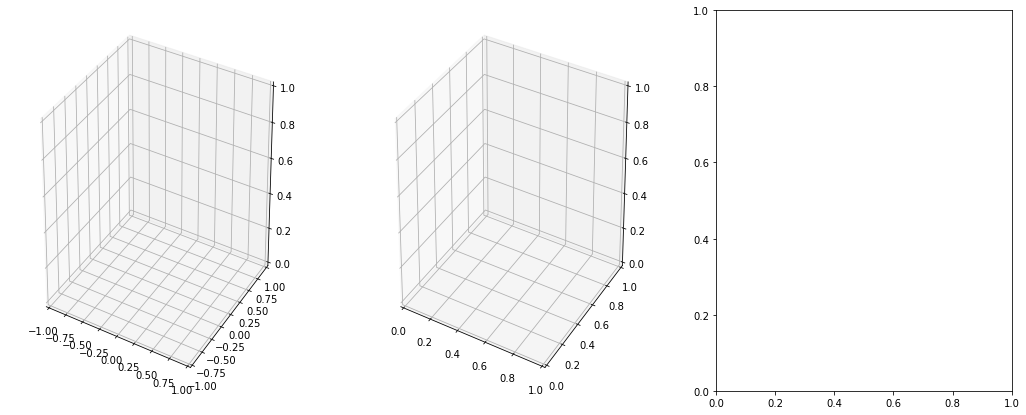

In [7]:
my_images = []
fig = plt.figure(figsize=(18,7))
ax = [fig.add_subplot(131, projection='3d'), fig.add_subplot(132, projection='3d'), fig.add_subplot(133)]
loss_hist = []

# train the network
n_epochs = 1000
for t in range(n_epochs):
    running_loss = 0.0
    epoch_steps = 0
    
    for data in trainloader:
        inputs, labels = data
  
        prediction = net(inputs)     # input x and predict based on x

        loss = net.loss(prediction, labels)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
        
        running_loss += loss.detach()
        epoch_steps += 1
    
    loss_hist.append(running_loss/epoch_steps)
    
    # plot and show learning process
    prediction = net(X)
    for ii in range(2):
        ax[ii].cla()
        ax[ii].set_xlim(-1, 1)
        ax[ii].set_ylim(-1, 1)
        #ax[ii].set_zlim(-0.02, 0.02)
        ax[ii].scatter(x[:,0].data.numpy(), x[:,1].data.numpy(), y[:,ii].data.numpy()/dt, color = "orange")
        ax[ii].plot_trisurf(x[:,0].data.numpy(), x[:,1].data.numpy(), prediction[:,ii].data.numpy(), alpha=0.4, shade=True)
        ax[ii].set_xlabel('$x_1$')
        ax[ii].set_ylabel('$x_2$')
        ax[ii].set_zlabel('$x_' + str(ii+1) + "'$")
        ax[ii].set_title('One-step-ahead state, $x_' + str(ii+1) + '$')
        ax[ii].view_init(30, 70)

    hist_index = max(0, t - 100)
    plot_max = 1.2*np.mean(loss_hist[hist_index:])
    ax[-1].cla()
    ax[-1].plot(range(len(loss_hist)), loss_hist)
    ax[-1].set_xlim(0, n_epochs)
    ax[-1].set_ylim(0, plot_max)
    ax[-1].set_title('Training loss')
    ax[-1].set_xlabel('Epochs')
    ax[-1].text(int(0.4*n_epochs), 0.5*plot_max, 'Step = %d' % t, fontdict={'size': 14, 'color':  'red'})
    ax[-1].text(int(0.4*n_epochs), 0.3*plot_max, 'Loss = %.8f' % loss_hist[-1],
                fontdict={'size': 14, 'color':  'red'})

    # Used to return the plot as an image array 
    # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    my_images.append(image)
    if t%1 == 0:
        print('Epoch: ', t, ', loss: ', loss.data.numpy())
    
# save images as a gif    
imageio.mimsave('figures/koop_simplified.gif', my_images, fps=10)

In [ ]:
# Check if learned lifting function is x^2:
prediction = net(X)
z = prediction.data.numpy()[:,2:5]
A = net.koopman_fc_drift.weight.detach().numpy()
print(z.shape, A.shape)
pred = z@A.T
print(pred.shape)

y_sq = x[:,0].pow(2)
plt.figure()
plt.scatter(x[:,0].data.numpy(), y_sq.data.numpy(), color = "orange", label='$x_1^2$')
plt.scatter(x[:,0].data.numpy(), pred[:,2], color='tab:blue', label='$z_1$')
plt.legend()
plt.show()

net.koopman_fc_drift.weight.detach().numpy()

In [ ]:
A = net.koopman_fc.weight.data.numpy()*dt
x_test = torch.Tensor(np.random.uniform(min_x, max_x, (n_pts,2)))  # x data (tensor), shape=(100, 1)
y_test = dt*np.concatenate((mu*x[:,0].reshape(-1,1), (-lambd*x[:,0].pow(2) + lambd*x[:,1]).reshape(-1,1)), 1)
phi_test = net(torch.cat((x_test, torch.zeros_like(x_test)), 1)).data.numpy()[:, 2]
print(phi_test.shape)
z_test = np.concatenate((x_test, phi_test.reshape(-1,1)), axis=1)
z_pred_test = (z_test@A.T)

print(z_test.shape, z_pred_test.shape)

plt.figure()
plt.subplot(1,2,1)
plt.plot(y_test[:,0] - z_pred_test[:,0])

plt.subplot(1,2,2)
plt.plot(y_test[:,1] - z_pred_test[:,1])

plt.show()

print(np.mean(np.square(z_pred_test[:, :2] - y_test[:, :2])))